In [1]:
import numpy as np
from drone_sac import AgentParallel3layers, BufferParallel
from drone_gym import DroneGym3
from tqdm.notebook import tqdm
import torch as T
import matplotlib.pyplot as plt

In [2]:
from distributed import Client, LocalCluster

n_workers  = 2
cl = Client(LocalCluster(n_workers=n_workers, threads_per_worker=1))
cl

Client Scheduler: tcp://127.0.0.1:50482 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 15.94 GiB


In [3]:
def generate_data3(agent_dict, agent_dict_md, n_points):
    try:
        import sys
        sys.path.append(r'D:\neuro_missile\src\cydrone')
        sys.path.append(r'D:\neuro_missile\src̚\drone_35_3')
        import numpy as np
        from drone_sac import AgentParallel3layers, BufferParallel
        from drone_gym import DroneGym3
        
#         import pickle
#         with open('agent_dict.bin', 'rb') as f:
#             agent_dict = pickle.load(f)
        
        env = DroneGym3.make()
        agent = AgentParallel3layers(
            input_dims=env.obs_max.shape, 
            n_actions=2, 
            action_space_high=env.action_space.high,
            device_name='cpu')
        agent.from_dict(agent_dict)
        buffer = BufferParallel(agent)

        agent_md = AgentParallel3layers(
            input_dims=env.obs_missile_max.shape, 
            n_actions=2, 
            action_space_high=env.action_space.high,
            device_name='cpu')
        agent_md.from_dict(agent_dict_md)
        buffer_md = BufferParallel(agent_md)
        
        env.record_history = False
        env.antiflip = False
        n = 0
        while n < n_points:
            observation, observation_md = env.reset()
            done = False
            done_md = False
            while (not done) and (not done_md):
                action = agent.choose_action(observation)
                action_md = agent_md.choose_action(observation_md)
                
                (observation_, reward, done, info), (observation_md_, reward_md, done_md, info_md) = env.step(action, action_md)
                
                buffer.store_transition(observation, action, reward, observation_, done)
                buffer_md.store_transition(observation_md, action_md, reward_md, observation_md_, done_md)
                
                observation = observation_
                observation_md = observation_md_
                n += 1
                if n >= n_points*2 :
                    return True, buffer.to_dict(), buffer_md.to_dict(), info
        return True, buffer.to_dict(), buffer_md.to_dict(), info
    except Exception as e:
        return False, {'error': str(e)}, {}, {}

In [4]:
env = DroneGym3.make()
agent = AgentParallel3layers(input_dims=env.obs_max.shape, n_actions=2, action_space_high=env.action_space.high)
buffer = BufferParallel(agent)

agent_md = AgentParallel3layers(
    input_dims=env.obs_missile_max.shape, 
    n_actions=2, 
    action_space_high=env.action_space.high)

buffer_md = BufferParallel(agent_md)

# import pickle
# with open('agent_dict3.bin', 'rb') as f:
#     agent_dict = pickle.load(f)
# agent.from_dict(agent_dict)

# import pickle
# with open('agent_dict3_md.bin', 'rb') as f:
#     agent_dict_md = pickle.load(f)
# agent_md.from_dict(agent_dict_md)

In [5]:
def run_parallel_sim(n):
    d = agent.to_dict()
    d_md = agent_md.to_dict()
    dicts_futs = cl.scatter([d] * n_workers)
    dicts_futs_md = cl.scatter([d_md] * n_workers)
    n_pointss = [n] * n_workers
    futs = cl.map(generate_data3, dicts_futs, dicts_futs_md, n_pointss, pure=False)
    return futs 


def extend_buff(futs):
    results = cl.gather(futs)
    for suc, points, points_md, info in results:
        infos.append(info)
        if suc:
            buffer.extend_from_dict(points)
            buffer_md.extend_from_dict(points_md)
            
def learn(batch_size, refresh=True):
    if refresh:
        buffer.refresh()
        buffer_md.refresh()
    losses = []
    losses_md = []
    for batch, batch_md in zip(buffer.iter_batches(batch_size), buffer_md.iter_batches(batch_size)):
        losses.append(agent.learn(*batch))
        losses_md.append(agent_md.learn(*batch_md))
    return np.mean(losses, axis=0), np.mean(losses_md, axis=0)

def plot_losses(ax_value, ax_actor, ax_critic, losses, losses_md):
    ax_value.plot([val for val, act, crit in losses], label='drone value')
    ax_actor.plot([act for val, act, crit in losses], label='drone actor')
    ax_critic.plot([crit for val, act, crit in losses], label='drone critic')
    
    ax_value.plot([val for val, act, crit in losses_md], label='drone_missile value')
    ax_actor.plot([act for val, act, crit in losses_md], label='drone_missile actor')
    ax_critic.plot([crit for val, act, crit in losses_md], label='drone_missile critic')
    
    ax_value.grid()
    ax_actor.grid()
    ax_critic.grid()
    
    ax_value.legend()
    ax_actor.legend()
    ax_critic.legend()

In [6]:
infos = []

In [7]:
futs = run_parallel_sim(3000)
extend_buff(futs)
learn(256)

(array([138.7894  ,  16.615784, 255.58128 ], dtype=float32),
 array([281.26465 ,  24.855207, 133.6465  ], dtype=float32))

In [8]:
losses = []
losses_md = []

In [9]:
for i in tqdm(range(3000)):
    futs = run_parallel_sim(7000)
    buffer.refresh()
    buffer_md.refresh()
    first = True
    while (not all([f.status in {'finished', 'error'} for f in futs])) or first:
        first = False
        alpha,beta=np.random.uniform(0.00001, 0.0003, size=2)
        agent.change_lr(alpha=alpha, beta=beta)
        alpha,beta=np.random.uniform(0.00001, 0.0003, size=2)
        agent_md.change_lr(alpha=alpha, beta=beta)
        los, los_md = learn(512, False)
        losses.append(los)
        losses_md.append(los_md)
    extend_buff(futs)   
    buffer.trim_oldest(1500000, False)
    buffer_md.trim_oldest(1500000, False) 
    
buffer.refresh(), buffer_md.refresh()

  0%|          | 0/3000 [00:00<?, ?it/s]

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

KeyboardInterrupt: 

In [ ]:
wi

In [16]:
print(buffer.refresh())

672651


In [99]:
agent.change_lr(alpha=0.0001, beta=0.0001)

In [14]:
print(buffer.refresh())
for i in tqdm(range(30)):
    losses.append(learn(2048, False))

1061974


  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

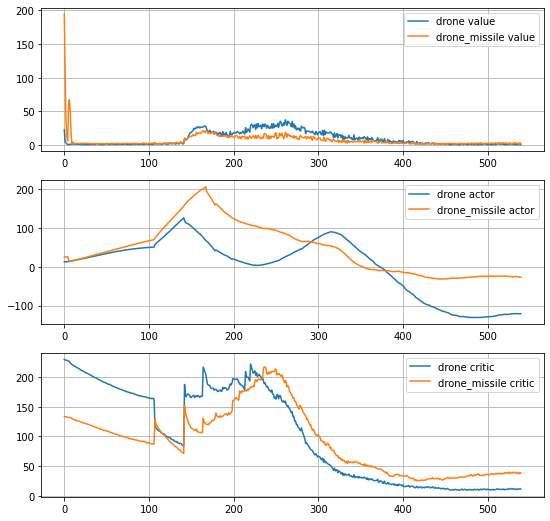

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(9,9))
plot_losses(ax1, ax2, ax3, losses[:], losses_md[:])
plt.show()

In [16]:
successes = [i for i in infos if 'result' in i and i['result'] == 'success']
len(successes)/len(infos)

0.0018115942028985507

In [17]:
successes = [i for i in infos if 'result_md' in i and i['result_md'] == 'success']
len(successes)/len(infos)

0.012681159420289856

In [17]:
infos[-100:]

[{'result': 'success',
  'final_reward': 17.32219604637113,
  'pos_diff': 0.06956177132813948,
  'dir_diff': 0.05118104277608648,
  'vel_diff': 1.5370449415538705},
 {'result': 'success',
  'final_reward': 18.991614543336695,
  'pos_diff': 0.21963163761388532,
  'dir_diff': 0.0038432724805319562,
  'vel_diff': 0.44550545309561074},
 {'result': 'success',
  'final_reward': 2.5452523925734756,
  'pos_diff': 0.8755664558585501,
  'dir_diff': 1.403027171599673,
  'vel_diff': 3.5308897350677046},
 {'result': 'success',
  'final_reward': 4.857436212347979,
  'pos_diff': 0.9594826579266248,
  'dir_diff': 1.6065985004752878,
  'vel_diff': 1.656078997821229},
 {'result': 'success',
  'final_reward': 5.800876598988582,
  'pos_diff': 0.97053481565951,
  'dir_diff': 1.3707671728818582,
  'vel_diff': 1.7463067291522887},
 {'result': 'success',
  'final_reward': 6.755300833082975,
  'pos_diff': 0.9567211743200785,
  'dir_diff': 1.1278732809991805,
  'vel_diff': 1.9108634451603652},
 {'result': 'succ

In [35]:
final_rewards = [i['final_reward'] for i in successes]
max(final_rewards), min(final_rewards), np.mean(final_rewards)

ValueError: max() arg is an empty sequence

In [11]:
import pickle
# with open('agent_dict2.bin', 'rb') as f:
#     agent_dict = pickle.load(f)
# agent.from_dict(agent_dict)

with open('agent_dict3.bin', 'wb') as f:
    pickle.dump(agent.to_dict(), f)
    
with open('agent_dict3_md.bin', 'wb') as f:
    pickle.dump(agent_md.to_dict(), f)

In [ ]:
with open('agent_dict3.bin', 'wb') as f:
    pickle.dump(agent.to_dict(), f)
    
with open('agent_dict3_md.bin', 'wb') as f:
    pickle.dump(agent_md.to_dict(), f)

In [101]:
env = DroneGym2.make(ay_missile=5, vel_missile=25)

In [109]:
score = 0
env.record_history = True
env.antiflip = False
for i in tqdm(range(1)):
    observation = env.reset()
    done = False
    score = 0
    while not done:
#         action = np.random.uniform(0.5,1, size=2)
        action = agent.choose_action_determ(observation)
#         action[0] *= 1.5
        observation_, reward, done, info = env.step(action)
        score += reward
#         buffer.store_transition(observation, action, reward, observation_, done)
        observation = observation_
#     buffer.refresh()

  0%|          | 0/1 [00:00<?, ?it/s]

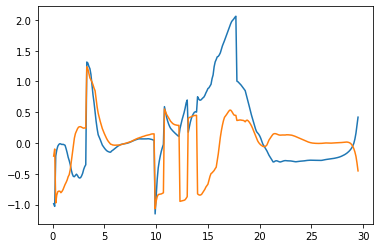

In [110]:
from ipywidgets import interact, interactive, fixed
import ipywidgets
import matplotlib.pyplot as plt
gym = env

xs = []
ys = []
f1s = []
f2s = []
rewards = []
ts = []
dts = []
scores = [0]
vels = []
xsm = []
ysm = []
omegas = []
for d in gym.history:
    gym.set_state(d['state'])
    xs.append(gym.drone.pos.x)
    ys.append(gym.drone.pos.y)
    omegas.append(gym.drone.omega)
    f1, f2 = d['actions']
    f1s.append(f1)
    f2s.append(f2)
    ts.append(gym.time_curr)
    rewards.append(d['reward'])
    dts.append(d['delta_t1'])
    scores.append(scores[-1]+d['reward'])
    vels.append(gym.drone.vel.len())
    xsm.append(gym.missile.pos.x)
    ysm.append(gym.missile.pos.y)
scores = scores[1:]
i1=0
i2=-1
# plt.plot(ts[i1:i2], rewards[i1:i2])
plt.plot(ts[i1:i2], f1s[i1:i2])
plt.plot(ts[i1:i2], f2s[i1:i2])
# plt.plot(ts[i1:i2], dts[i1:i2])

In [111]:
@interact(i=ipywidgets.IntSlider(min=0,max=len(gym.history)-1,step=1, value=0),
         ideal_traj=ipywidgets.Checkbox(value=True, description ='(зел) оценка траетктории до цели'),
         drone_traject=ipywidgets.Checkbox(value=True, description ='(синяя) траектория дрона '),
         missile_traject=ipywidgets.Checkbox(value=True, description ='(красная) траектория ракеты '))
def plot_history(i,ideal_traj,drone_traject, missile_traject):
    d = gym.history[i]
    i1=0#max(0,i-30)
    i2=i+1
    gym.set_state(d['state'])
    fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(14,7))
    gym.plot(ax, drone_mashtb=50, vec_mashtb=10, actions=d['actions'],ideal_traj=ideal_traj, missile_d=True, missile_vec_mshtb=10)
    if drone_traject:
        ax.plot(xs[i1:i],ys[i1:i],ls=':',c='blue')
    if missile_traject:
        ax.plot(xsm[i1:i],ysm[i1:i],ls=':',c='red')
    ax.set_aspect('equal', adjustable='box')
    
    
#     ax2.plot(ts[i1:i2], f1s[i1:i2])
#     ax2.plot(ts[i1:i2], f2s[i1:i2])
    ax2.grid()
    ax2.plot(ts[:i2], vels[:i2])
#     ax2.plot(ts[:i2], omegas[:i2])
    
    ax3.plot(ts[:i2], rewards[:i2])
    ax3.grid()
    ax.grid()
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=295), Checkbox(value=True, description='(зел) оц…

In [112]:
info

{'result': 'success',
 'final_reward': 15.771170371713033,
 'pos_diff': 0.24170582383008773,
 'dir_diff': 0.16247131776838986,
 'vel_diff': 1.6039719601472895}

In [108]:
import numpy as np

In [39]:
np.random.lognormal()

1.2592890447856777